# Notebook 2: Using Regressions to Predict Age-of-Death of Skeletal Remains

In archaeology, a regression is a type predictive model in which we use **measured attributes from known examples** to predict **outcomes for new finds**. 

- **Dependent Variable:** The single numerical value we want our model to estimate for each new observation, also called an outcome variable. Typically denoted using $Y_i$. 

- **Independent Variables**: The measurements or attributes we use to explain or predict our dependent variable, usually denoted using $X_{ij}$. 

Our dependent variable might be something like an individual’s age at death, estimated from osteometric measurements, or the approximate date of an artifact, inferred from its dimensional and compositional features. For instance, we could use a suite of cranial measurements collected from skeletal remains to predict a individual's age, or leverage sherd thickness, fabric inclusions, and decoration motifs to estimate an artifact’s production century.

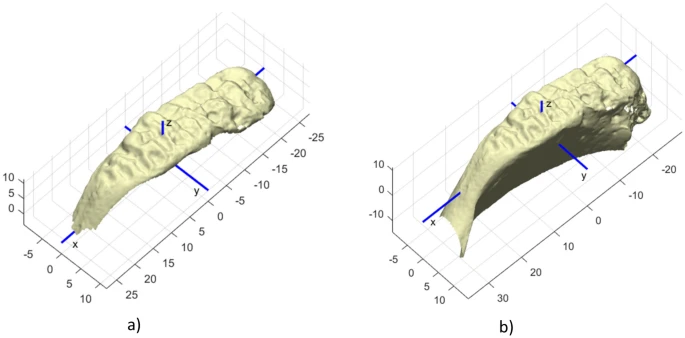

Much arecheological research goes into reconstructing information about skeletal remains. This often poses a significant challenge-- remains are often poorly preseved, for instane, taphonomic damage such as weathering and soil activity can erode features archeologists use for identification, and many skeletal remains are incomplete, lacking bones that exibit diagnostic traits for ancestry/sex/age/stature identification such as the pelvis and pubic symphysis. Additionally, the osteoloical standards used for grouping remains were primarily developed on 19th and 20th century European collections, making applying them to prehistroic or non-european populations innacurate. 

<div class="alert alert-block alert-warning">
<b>Emphasizing ancestry over race:</b> 

Early physical anthropologists attempted to divide humans into a few “continental races” based on cranial measurements and other morphological traits. Not only were these typological methods arbitrary and varied wildly between scholars, but where deeply rooted in colonialism, eugenics, and scientific racism. The concept of a distinct set of races rooted in biology was widely used to justify discrimination and colonial domination: measurements of morphological traits were used to legitimize chattel slavery in the United States, and were used to justify seperate schooling and differential legal codes for Algerian rersidents well after World War II. Modern archeologists now frame bone-based classifications of skeletal remains in terms of clinical variation (gradual changes across geography) amd genomic population structure rather than discrete race boxes. The American Association of Physical Anthropologists writes: “Race does not provide an accurate representation of human biological variation. It was never accurate in the past, and it remains inaccurate when referencing contemporary human populations. Humans are not divided biologically into distinct continental types or racial genetic clusters…”. 

In short, archeologists must be very careful in how they frame their analyses of skeletal morphology, and not use race as a biological descriptor, rather framing analyses in terms of ancestry, population affinity, and clinical variation. 
</div>

Here is where predictive models step in: while each individual measurement such as head diameter and orbital breadth might correlate only weakly with age/sex/ancestry/stature on it's own, a multivariate model aggregates dozens of these small signals into a sharper, more reliable prediction. Predictive models can "fill the gaps" where information is missing for a given observation, by learning how the measurements we *do have* co-vary with our attribute(s) of interest. We build a sort of mathematical "recipe" from a set of speciments for which we know both the measurements *and the true outcomes*, then apply that recipe onto the observations for which our attriburtes of interest aren't known.

![amne_notebooks\regression_demo_1.png](amne_notebooksregression_demo_1.png)


Among the many regression techniques available, the K-nearest neighbors (KNN) algorithm is particularly intuitive and flexible. In short, to apply KNN, we first assemble a reference dataset of specimens whose ages or dates are reliably known—perhaps through radiocarbon dating or historical documentation. Each new specimen is then compared to its K most similar neighbors (e.g., measurements of bone lengths, cortical thickness, strontium ratios, decoration counts), and its predicted age or date is calculated to be the average value of those neighbors.

## 1.2 Exploring the dataset

The **Goldman Osteometric Dataset** is a collection of 1538 osteometric measurements taken from a sample of human skeletons belonging to various periods of the Holocene. The dataset contains measurements for the femur, tibia, radius, pelvis, and humerus. Some interesting/relevant metadata includes:

- IDNST: Institute from which the given sample was provided from.

- Sex: Is the sample male or female? Determined using the os coaxae and occasionally with cranial statistics.

- Age: Age range at death, based on public symphysis and auricular surface. 

- Note: The site of origin location.

The measurements we will be focusing on are the **maximal length of the humerus**, the **Radius maximum length**, the **femur maximum length**, and the **tibia maximum length**. 

In [195]:
# A whole lot of packages...

import altair as alt
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
from pytimetk import glimpse
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from ipywidgets import interact, IntSlider, Dropdown, Checkbox
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union
import geoplot as gplt
import matplotlib.pyplot as plt
import contextily as ctx
from geopy.geocoders import Nominatim
from folium import Map, CircleMarker
from folium.plugins import HeatMap
import branca.colormap as cm
import numpy as np
import plotly.graph_objects as go
from sklearn.neighbors import KNeighborsRegressor
from ipywidgets import interact, IntSlider
import re


Move the slider to the left/right to scroll through the dataset:

In [207]:
set_config(transform_output="pandas")

np.random.seed(10)

goldman_skeletons = pd.read_csv('Goldman.csv', encoding="utf-8")

@interact(n=IntSlider(min=5, max=50, step=5, value=10, description="Rows"))
def view_head(n):
    display(goldman_skeletons.head(n))

interactive(children=(IntSlider(value=10, description='Rows', max=50, min=5, step=5), Output()), _dom_classes=…

Next, we'll do some quick pre-processing. We'll remove unnecessary columns, keeping only those we went for our analysis. 

In [208]:
goldman_skeletons = goldman_skeletons[['Sex','Age','NOTE','RFML','RHML','RRML','RTML','RIBL']]

cols = ['RFML','RHML','RRML','RTML','RIBL','Age']
goldman_skeletons = goldman_skeletons[cols].copy()

for m in ['RFML','RHML','RRML','RTML','RIBL']:
    goldman_skeletons[m] = pd.to_numeric(goldman_skeletons[m], errors='coerce')

def age_to_first_number(a):
    if pd.isna(a):
        return np.nan
    s = str(a)
    match = re.search(r'\d+', s)
    return float(match.group(0)) if match else np.nan

goldman_skeletons['Age'] = goldman_skeletons['Age'].apply(age_to_first_number)

goldman_skeletons_clean = goldman_skeletons.dropna(subset=['RFML','RHML','RRML','RTML','RIBL','Age'])

print("Rows remaining:", len(goldman_skeletons_clean))
print(goldman_skeletons_clean.head())

Rows remaining: 896
    RFML   RHML   RRML   RTML   RIBL   Age
3  400.0  298.0  227.0  320.5  145.0  25.0
4  396.0  302.0  205.0  305.0  155.0  50.0
7  437.0  322.0  238.0  364.0  156.0  30.0
8  407.0  307.0  235.0  338.0  161.0  30.0
9  386.0  292.5  214.0  315.0  160.0  50.0


In [200]:
num_cols = goldman_skeletons.select_dtypes(include=['number']).columns.tolist()
print("Numeric columns:", num_cols)
@interact(
    x=Dropdown(options=num_cols, description="X"),
    y=Dropdown(options=num_cols, description="Y"),
    color=Dropdown(options=['Age','Sex'] + num_cols, description="Color by")
)
def scatter(x, y, color):
    fig = px.scatter(
        goldman_skeletons,
        x=x,
        y=y,
        color=color,
        title=f"{y} vs {x}" + (f" colored by {color}" if color else "")
    )
    fig.show()

Numeric columns: ['RFML', 'RHML', 'RRML', 'RTML', 'RIBL']


interactive(children=(Dropdown(description='X', options=('RFML', 'RHML', 'RRML', 'RTML', 'RIBL'), value='RFML'…

We'll also clean up the notes column, by converting the strings corresponding to locations to numeric longitude/latitude coordinates. 

In [180]:
sites = goldman_skeletons['NOTE']
print(f"Total unique sites to geocode: {len(sites)}")


geolocator = Nominatim(user_agent="archaeo_mapper")
coords = {}
for site in sites:
    try:
        loc = geolocator.geocode(f"{site}, USA")
        if loc:
            coords[site] = (loc.longitude, loc.latitude)
    except Exception:
        pass

print(f"Number of sites successfully geocoded: {len(coords)}")



Total unique sites to geocode: 1538


KeyboardInterrupt: 

In [ ]:

goldman_skeletons_folium = goldman_skeletons.dropna(subset=['lon','lat']).copy()
center = [goldman_skeletons_folium['lat'].mean(), goldman_skeletons_folium['lon'].mean()]
m = Map(location=center, zoom_start=4, tiles='CartoDB positron')

heat_data = [
    [row['lat'], row['lon'], 1.0]
    for idx, row in goldman_skeletons_folium.iterrows()
]

m.add_child(HeatMap(
    heat_data,
    min_opacity=0.3,
    max_zoom=10,
    radius=50,
    blur=30,
    gradient={0.0: 'navy', 0.2: 'blue', 0.4: 'lime', 0.6: 'yellow', 0.8: 'orange', 1.0: 'red'},
    name='Site Density'
))

for idx, row in goldman_skeletons_folium.iterrows():
    CircleMarker(
        location=(row['lat'], row['lon']),
        radius=3,
        color='black',
        fill=True,
        fill_opacity=0.6
    ).add_to(m)

colormap = cm.LinearColormap(
    ['navy','blue','lime','yellow','orange','red'],
    vmin=0, vmax=1
)
colormap.caption = 'Relative Site Density' 
colormap.add_to(m)

m.save('archaeo_heatmap.html')



KeyError: ['lon', 'lat']

## 2. An overview of KNN regression

So how exactly do we predict the age-of-death of a bone specimen? The first model we'll introduce is called a **KNN regression**. The basic ideas is quite simple:

*"Tell me about your neighbors, and I'll tell you your age."*

Imagine each of our known skeletons is a point in a 2D space, where the X-axis is some predictor variable (such as femur length) and the Y-axis is the age of each sample. Realistically, each point would sit in a *multidimensional space*, with each dimension corresponding to one of our predictor variables. When we uncover a new skull, we locate it's position in that same space. Note that, crucially, we don't know the age of death of the skeleton- only it's femur length. We then ask,

*"Which $K$ known skeletons are closest to this skeleton?"*

The new skeleton's age is the average of those neighbors' ages.

If we treat each possible value of $X$ as a red dot, we get a **KNN regression line**: each point on the line corresponds to the predicted age-of-death for a potention skeleton with that particular femur length. Try modifying the value of $k$ below, and see how the regression line changes.

In [211]:

@interact(
    k=IntSlider(min=1, max=30, step=1, value=5, description="Neighbors (k)")
)
def plot_knn_age_vs_rhml(k):

    X_rhml = goldman_skeletons_clean['RFML'].values.reshape(-1, 1)
    y_age  = goldman_skeletons_clean['Age'].values

    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_rhml, y_age)
    x_grid = np.linspace(X_rhml.min(), X_rhml.max(), 300).reshape(-1, 1)
    y_pred = knn.predict(x_grid)

    fig = go.Figure([
        go.Scatter(
            x=X_rhml.flatten(), y=y_age,
            mode='markers', marker=dict(opacity=0.6),
            name='Data points'
        ),
        go.Scatter(
            x=x_grid.flatten(), y=y_pred,
            mode='lines', line=dict(width=3),
            name=f'KNN fit (k={k})'
        )
    ])
    fig.update_layout(
        title=f"KNN Regression of Age vs RHML (k={k})",
        xaxis_title="RHML",
        yaxis_title="Age"
    )
    fig.show()

interactive(children=(IntSlider(value=5, description='Neighbors (k)', max=30, min=1), Output()), _dom_classes=…

The first thing we notice is that our regression line is relatively flat. No matter what RHML value our red dot takes on, it's age stays relatively the same. But how do we determine how many neighbors to use? Is there an optimal number? Yes! 

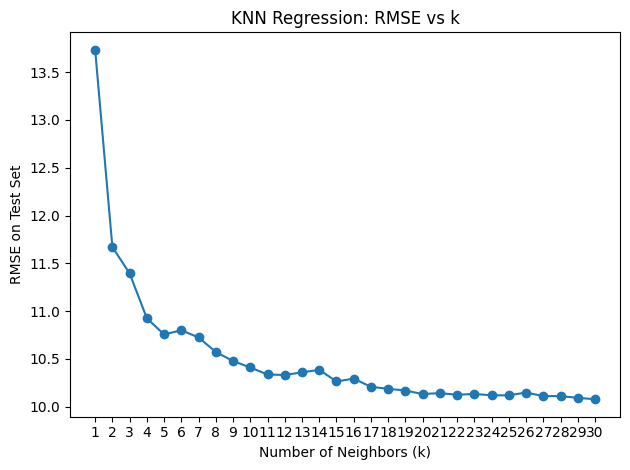

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X = df_clean[['RHML']].values  
y = df_clean['Age'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

ks = range(1, 31)
rmse_vals = []

for k in ks:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_vals.append(rmse)

plt.figure()
plt.plot(ks, rmse_vals, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('RMSE on Test Set')
plt.title('KNN Regression: RMSE vs k')
plt.xticks(ks)
plt.tight_layout()
plt.show()


In [214]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(
    KNeighborsRegressor(),
    {'n_neighbors': list(range(1,31))},
    cv=5,
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1
)
grid.fit(X_train, y_train)

means = -grid.cv_results_['mean_test_score']
stds  =  grid.cv_results_['std_test_score']

min_idx    = np.argmin(means)
min_mse    = means[min_idx]
one_se     = stds[min_idx]
threshold  = min_mse + one_se

ks         = grid.cv_results_['param_n_neighbors'].data
candidate_ks = [k for k, m in zip(ks, means) if m <= threshold]
k_one_se   = min(candidate_ks)

print(f"True min MSE at k={ks[min_idx]} with RMSE={np.sqrt(min_mse):.2f}")
print(f"One‐SE rule selects k={k_one_se}")


True min MSE at k=30 with RMSE=9.80
One‐SE rule selects k=7


In [ ]:
@interact(feature=features)
def plot_feature_distribution(feature):
    fig = px.box(goldman_skeletons_final, x='Age', y=feature, color='Age', 
                 title=f"Distribution of {feature} by Age-at-Death Category",
                 labels={feature: f"{feature} (mm)"})
    fig.update_layout(xaxis_title="Age-at-Death Category", yaxis_title=f"{feature} (mm)", showlegend=False)
    fig.show()

interactive(children=(Dropdown(description='feature', options=('LHML', 'LHHD', 'LFML', 'LFHD', 'LFMLD', 'LTML'…